<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/3_reduce_feature_length_with_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before we start you need to add the Caltech 101 dataset to your Google Colab enviroment. Here is the [link](https://www.kaggle.com/ceciliala/caltech-101).

In [1]:
# Kaggle dependencies will already be installed so there is no need for "!pip install kaggle"
# You'll need to upload your kaggle.json file though

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samuelbfg","key":"0720c91e1f13c46c81f9cf850f621e4e"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Adding dataset
!kaggle datasets download -d ceciliala/caltech-101

100% 115M/115M [00:01<00:00, 40.7MB/s]
100% 115M/115M [00:01<00:00, 72.4MB/s]


In [4]:
from zipfile import ZipFile
file_name = "caltech-101.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Here we are going to use the files in the ***data*** folder we obtained from the previous notebook ***1-feature-extraction***

The files that we are going to need are:

```
   class_ids-caltech101.pickle
   features-caltech101-resnet.pickle
   features-caltech101-resnet-finetuned.pickle
   filenames-caltech101.pickle
```

In [5]:
from zipfile import ZipFile
file_name = "data.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Improving the speed of feature extraction and similarity search

We will experiment with PCA and figure out what is the optimum length of the features to use in our experiments.

## Reduce feature length with PCA

PCA (short for Principal Component Analysis) is a statistical procedure that questions if features representing the data are equally important. Are some of the features redundant enough that we can get similar results on say classification even after removing those features? PCA is considered one of the go-to techniques for dimensionality reduction. Note that it does not eliminate redundant features, instead it generates a new set of features that are a linear combination of the input features. These linear features are orthogonal to each other, which is why all the redundant features are absent. These features are known as principal components. 


Performing PCA is pretty simple, using the scikit-learn library.

In [6]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160


You can run the following code on either the Caltech101 or the Caltech256 dataset. Run either one of the following two blocks of code to load the desired dataset.

In [18]:
filenames = pickle.load(open('/content/data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('/content/data/features-caltech101-resnet.pickle',
                                'rb'))
class_ids = pickle.load(open('/content/data/class_ids-caltech101.pickle', 'rb'))

In [19]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [20]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [21]:
print("Accuracy on original feature set : ",
      calculate_accuracy(feature_list[:]))

Accuracy on original feature set :  (88.36, 776.5944344997406)


In [22]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  17.92 % ,	Time =  5.828105449676514
For PCA Dimensions =  2 ,	Accuracy =  26.82 % ,	Time =  6.22467303276062
For PCA Dimensions =  3 ,	Accuracy =  33.71 % ,	Time =  6.626328229904175
For PCA Dimensions =  4 ,	Accuracy =  40.5 % ,	Time =  6.868451356887817
For PCA Dimensions =  5 ,	Accuracy =  46.38 % ,	Time =  7.675340175628662
For PCA Dimensions =  10 ,	Accuracy =  66.37 % ,	Time =  13.8179349899292
For PCA Dimensions =  20 ,	Accuracy =  79.65 % ,	Time =  16.842057466506958
For PCA Dimensions =  50 ,	Accuracy =  86.85 % ,	Time =  33.4448299407959
For PCA Dimensions =  75 ,	Accuracy =  88.0 % ,	Time =  42.529062271118164
For PCA Dimensions =  100 ,	Accuracy =  88.48 % ,	Time =  51.759965896606445
For PCA Dimensions =  150 ,	Accuracy =  88.75 % ,	Time =  71.74521207809448
For PCA Dimensions =  200 ,	Accuracy =  88.82 % ,	Time =  93.09734463691711


Let's plot the test time accuracy for each PCA dimension.

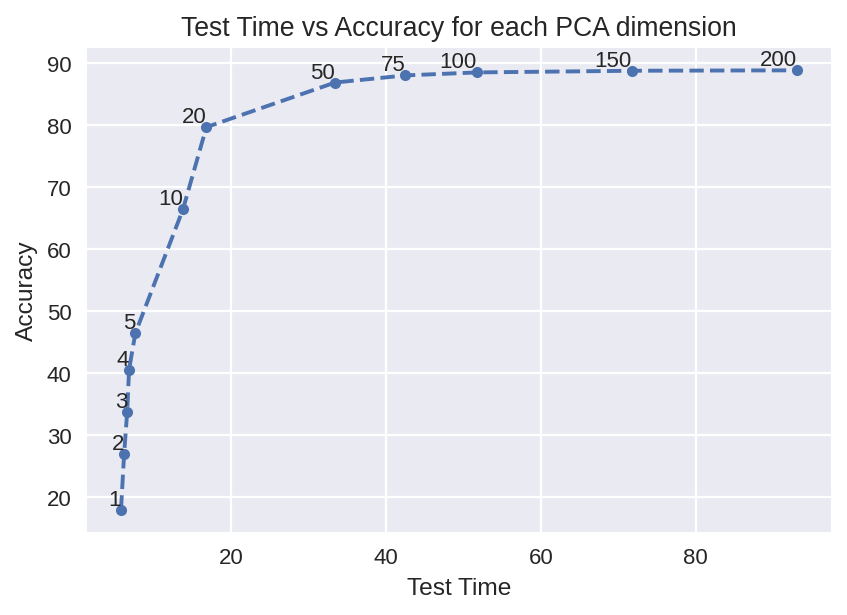

In [23]:
from itertools import zip_longest as zip
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("pca-test_time_vs_acc.pdf", bbox_inches='tight')
f.savefig("pca-test_time_vs_acc.png", bbox_inches='tight')

In [24]:
f.savefig('pca-test_time_vs_acc.pdf', bbox_inches='tight')
f.savefig('pca-test_time_vs_acc.png', transparent=False, bbox_inches='tight')

As visible in the graph, there is little improvement in accuracy after increasing beyond feature length of 100 dimensions. With almost 20 times lesser dimensions (100) that the original (2048), this offers drastically higher speed and less time on almost any search algorithm, while getting similar (and sometimes slightly better) accuracy. Hence, 100 would be an ideal feature length for this dataset. This also means that the first 100 dimensions contain the most information about the dataset.


Let's plot the variance of each PCA dimension.

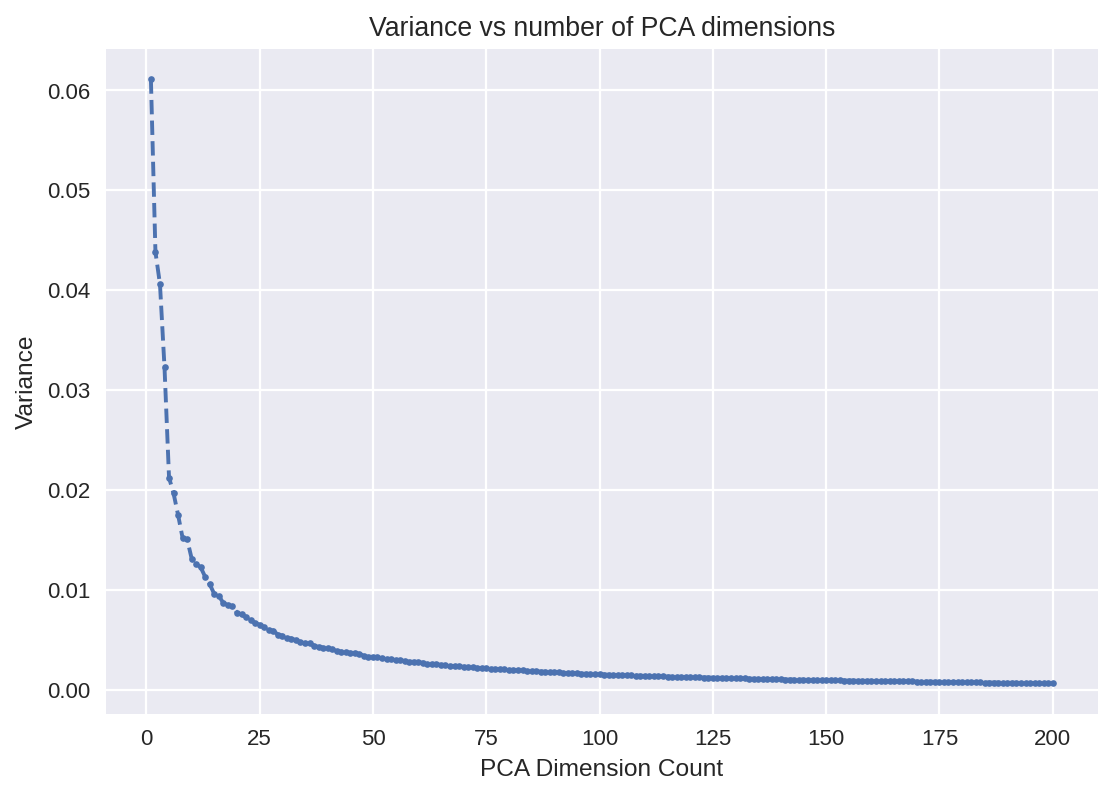

In [25]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201), pca.explained_variance_ratio_, 'o--', markersize=3)
plt.title('Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

f.savefig("Variance vs number of PCA dimensions.pdf", bbox_inches='tight')
f.savefig("Variance vs number of PCA dimensions.png", bbox_inches='tight')

The individual variance will tell us how important the newly added features are. For example, after the first 100 dimensions, the additional dimensions don’t add much variance (almost equal to 0) and can be neglected. Without even checking the accuracy it is safe to assume that the PCA with 100 dimensions will be a  robust model. Another way to look at this is to visualize how much of the original data is explained by the limited number of features by finding the cumulative variance.

### Cumulative Variance vs number of PCA dimensions.

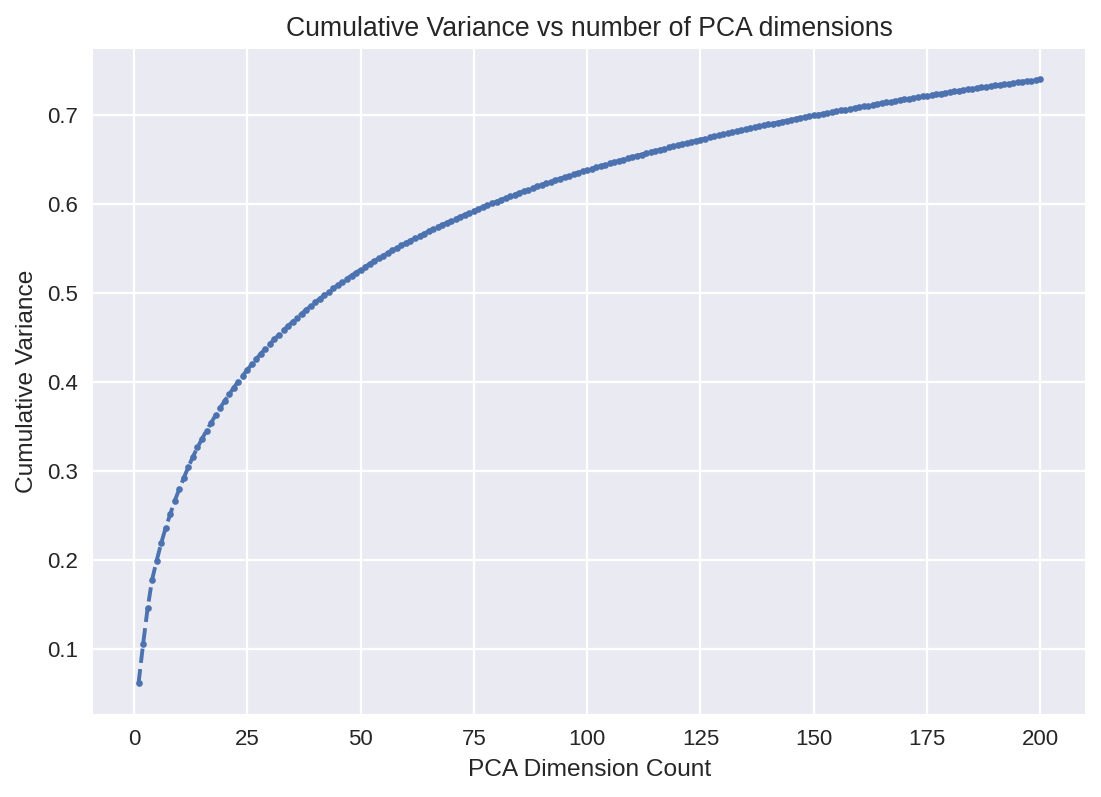

In [26]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201),
         pca.explained_variance_ratio_.cumsum(),
         'o--',
         markersize=3)
plt.title('Cumulative Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

f.savefig("Cumulative Variance vs number of PCA dimensions.pdf",
          bbox_inches='tight')
f.savefig("Cumulative Variance vs number of PCA dimensions.png",
          bbox_inches='tight')

As expected adding 100 dimensions (from 100 to 200) adds only .1 variance and starts to gradually plateau. For reference, using full 2048 features would result in a cumulative variance of 1. 


### Plotting the effect of PCA dimension vs Classification Accuracy.

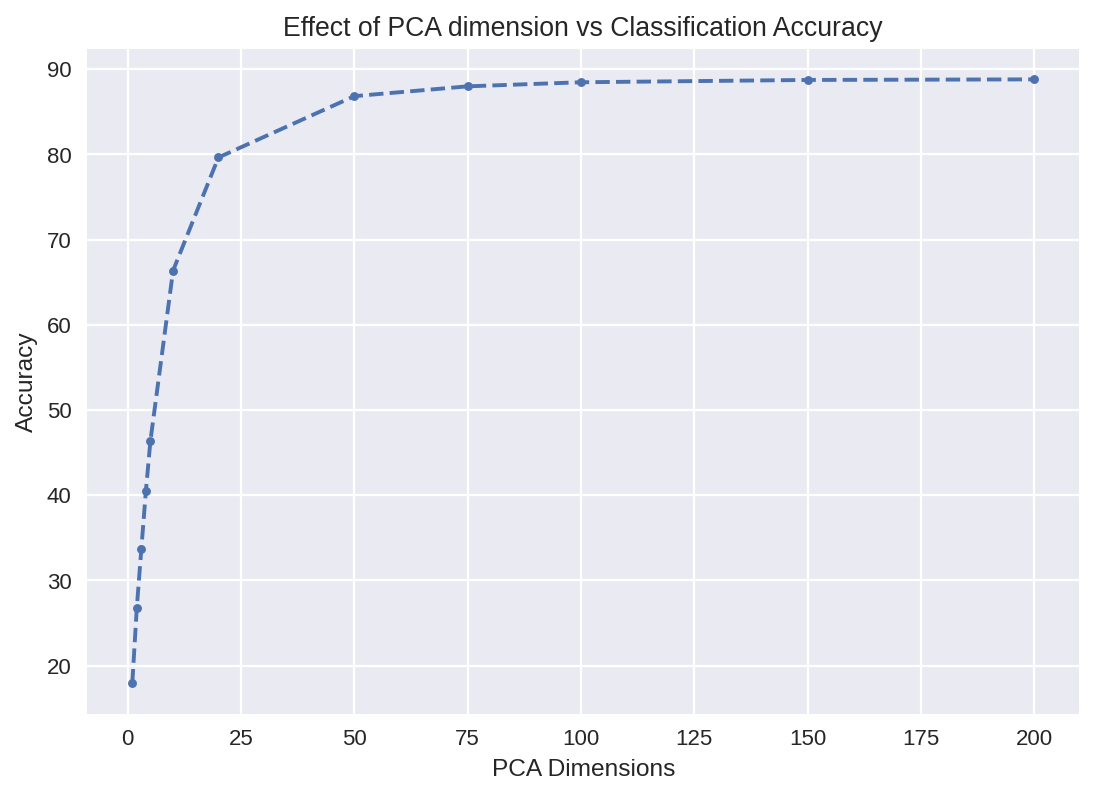

In [27]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_accuracy, 'o--', markersize=4)
plt.title('Effect of PCA dimension vs Classification Accuracy')
plt.xlabel('PCA Dimensions')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimension vs Classification Accuracy.pdf",
          bbox_inches='tight')
f.savefig("Effect of PCA dimension vs Classification Accuracy.png",
          bbox_inches='tight')

As visible in the graph, there is little improvement in accuracy after increasing beyond feature length of 100 dimensions. With almost 20 times lesser dimensions (100) that the original (2048), this offers drastically higher speed and less time on almost any search algorithm, while getting similar (and sometimes slightly better) accuracy. Hence 100 would be an ideal feature length for this dataset.

We will now plot the effect of number of PCA dimensions vs time.

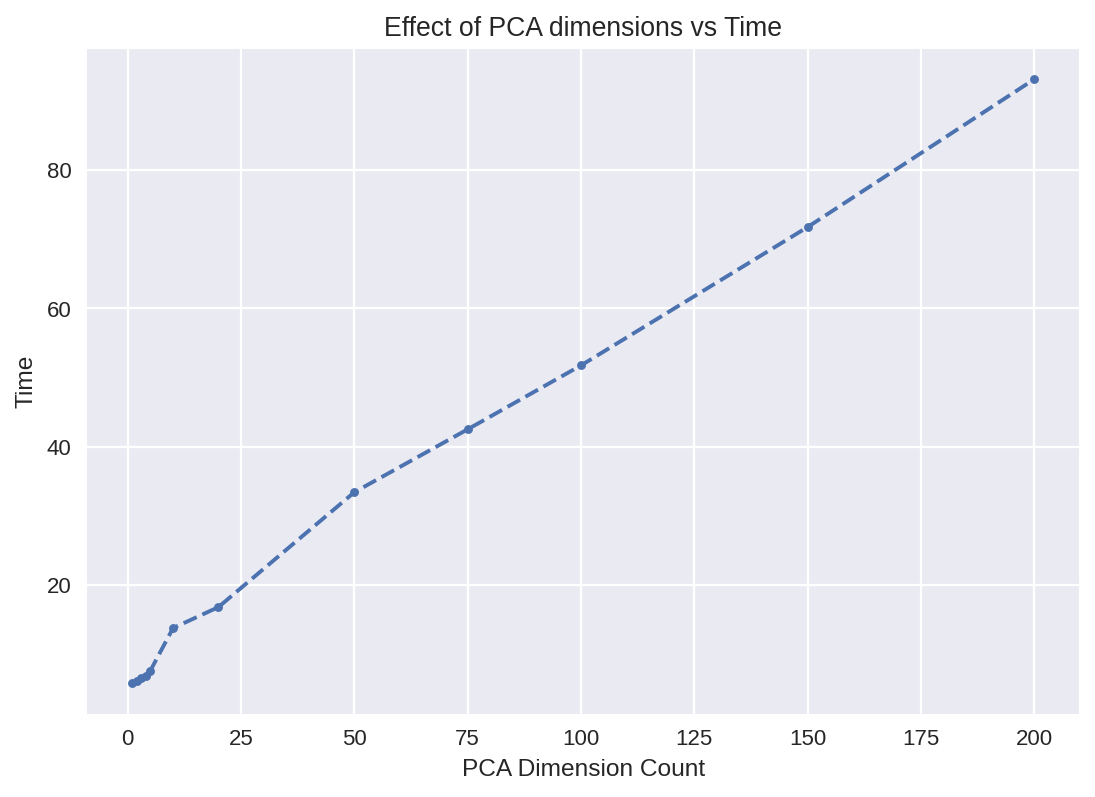

In [28]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_time, 'o--', markersize=4)
plt.title('Effect of PCA dimensions vs Time')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Time')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimensions vs Time.pdf", bbox_inches='tight')
f.savefig("Effect of PCA dimensions vs Time.png", bbox_inches='tight')

Now let's compare different options available for similarity search

In [29]:
num_items = 8500
num_dimensions = 100

In [30]:
dataset = np.random.randn(num_items, num_dimensions)
dataset /= np.linalg.norm(dataset, axis=1).reshape(-1, 1)

In [31]:
randomIndex = random.randint(0, num_items)
query = dataset[randomIndex]

### Brute force

In [32]:
# Time the indexing for the brute force algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(dataset)

1000 loops, best of 3: 408 µs per loop


In [33]:
# Time the search for the brute force algorithm
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(dataset)
%timeit neighbors.kneighbors([query])

100 loops, best of 3: 2.58 ms per loop


### k-d Tree

In [34]:
# Time the indexing for the k-d tree algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dataset)

10 loops, best of 3: 101 ms per loop


In [35]:
# Time the search for the k-d tree algorithm
neighbors = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

100 loops, best of 3: 3.71 ms per loop


### Ball Tree

In [36]:
# Time the indexing for the Ball Tree algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(dataset)

10 loops, best of 3: 62.1 ms per loop


In [37]:
# Time the search for the Ball Tree algorithm
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

100 loops, best of 3: 2.52 ms per loop


In [38]:
!pip3 install annoy

     |████████████████████████████████| 655kB 4.3MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp36-cp36m-linux_x86_64.whl size=390373 sha256=1d928e13c0e0128a5426d3007af0ed177836dfa4f1438ac4d10a295c80a13927
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


Now we have seen the time it takes to index and search using nearest neighbor algorithms on the full feature length. Now, We will use enhanced searching techniques like Faiss and Annoy to compress the features and reduce the time 

### Annoy

Annoy (Approximate Nearest Neighbors Oh Yeah) is a C++ library with Python bindings for searching nearest neighbors. Synonymous with speed, it was released by Spotify and is used in production to serve their music recommendations. 

To use annoy, install it using pip:  `pip3 install annoy`

In [39]:
from annoy import AnnoyIndex

In [40]:
# Choose a random image to experiment
random_image_index = random.randint(0, num_items)
# Note: the results may change if the image is changed

First, we build a search index with two hyperparameters - the number of dimensions of the dataset, and the number of trees. 

In [41]:
annoy_index = AnnoyIndex(
    num_dimensions)  # Length of item vector that will be indexed
for i in range(num_items):
    annoy_index.add_item(i, dataset[i])
annoy_index.build(40)  #40 trees

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

Now let’s find out the time it takes to search the 5 nearest neighbors of one image.

In [42]:
#u = AnnoyIndex(num_dimensions)
#Time the search for one image for Annoy
%timeit annoy_index.get_nns_by_vector(query, 5, include_distances=True )

The slowest run took 7.41 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 36.5 µs per loop


Now THAT is blazing fast! To put this in perspective, for such a modestly sized dataset, this can serve almost 15000 requests on a single CPU core. Considering most CPUs have multiple cores, it should be able to handle 100K+ requests on a single system. The best part is that it lets you share the same index in memory between multiple processes. Hence, the biggest index can be equivalent to the size of your overall RAM, making it possible to serve multiple requests on a single system. 

Other benefits include that it generates a modestly sized index. Moreover, it decouples creating indexes from loading them, so you can create an index on one machine, pass it around and then on your serving machine, load it in memory and serve it. 

Let's time the indexing for different number of tree:

In [43]:
annoy_training_time = []
annoy_test_time = []
annoy_trees = [
    1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300
]
for num_trees in annoy_trees:
    t = AnnoyIndex(2048)  # Length of item vector that will be indexed
    for i in range(num_images):
        feature = feature_list[i]
        t.add_item(i, feature)
    start_time = time.time()
    t.build(num_trees)  #50 trees
    end_time = time.time()
    annoy_training_time.append(end_time - start_time)
    start_time = time.time()
    indices = t.get_nns_by_vector(feature_list[random_image_index],
                                  5,
                                  include_distances=True)
    end_time = time.time()
    annoy_test_time.append(end_time - start_time)
    print("For number of trees = ", num_trees, ",\tTime to train = ",
          annoy_training_time[-1], ",\tTime to test = ", annoy_test_time[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  import sys


For number of trees =  1 ,	Time to train =  0.020959854125976562 ,	Time to test =  0.0018954277038574219
For number of trees =  2 ,	Time to train =  0.033158063888549805 ,	Time to test =  0.00177764892578125
For number of trees =  3 ,	Time to train =  0.05991411209106445 ,	Time to test =  0.0017724037170410156
For number of trees =  4 ,	Time to train =  0.0711669921875 ,	Time to test =  0.0016071796417236328
For number of trees =  5 ,	Time to train =  0.09201955795288086 ,	Time to test =  0.0023698806762695312
For number of trees =  10 ,	Time to train =  0.17948698997497559 ,	Time to test =  0.0015513896942138672
For number of trees =  20 ,	Time to train =  0.36453914642333984 ,	Time to test =  0.001600027084350586
For number of trees =  30 ,	Time to train =  0.5568568706512451 ,	Time to test =  0.0019421577453613281
For number of trees =  40 ,	Time to train =  0.7388381958007812 ,	Time to test =  0.001960277557373047
For number of trees =  50 ,	Time to train =  0.9423468112945557 ,	Ti

### Effect of number of trees vs Training time

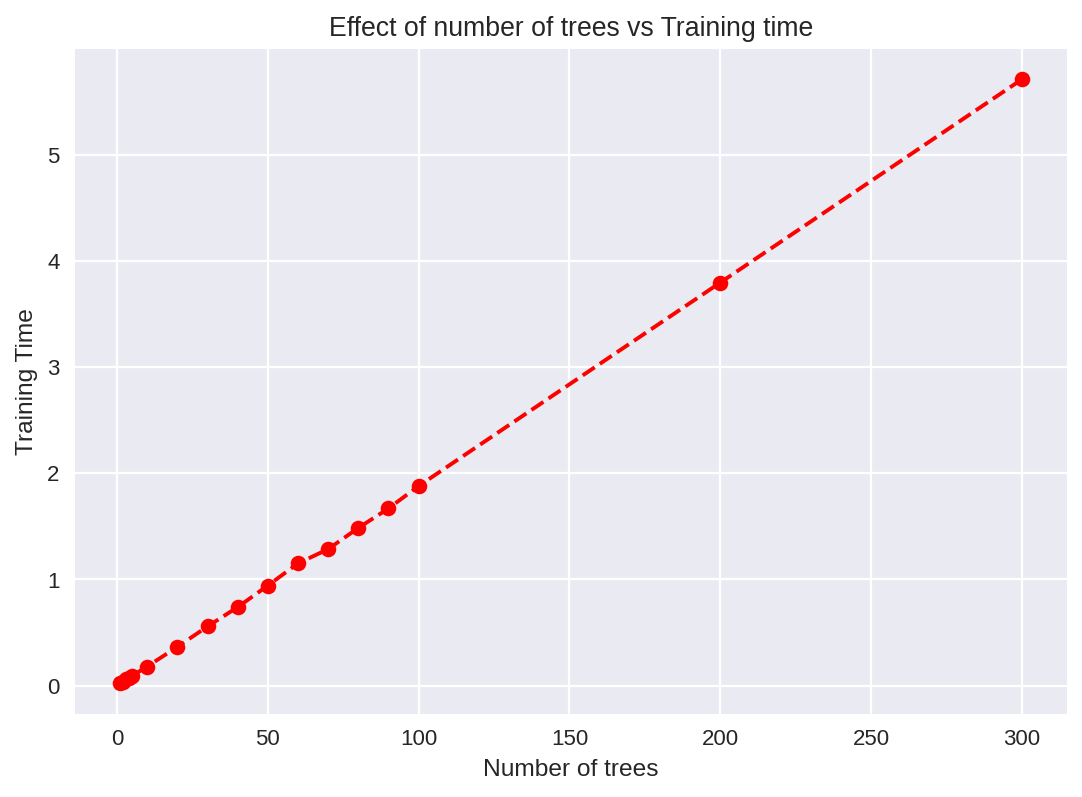

In [44]:
plt.plot(annoy_trees, annoy_training_time, 'or--')
plt.title('Effect of number of trees vs Training time')
plt.xlabel('Number of trees')
plt.ylabel('Training Time')
plt.grid(True)
plt.show()

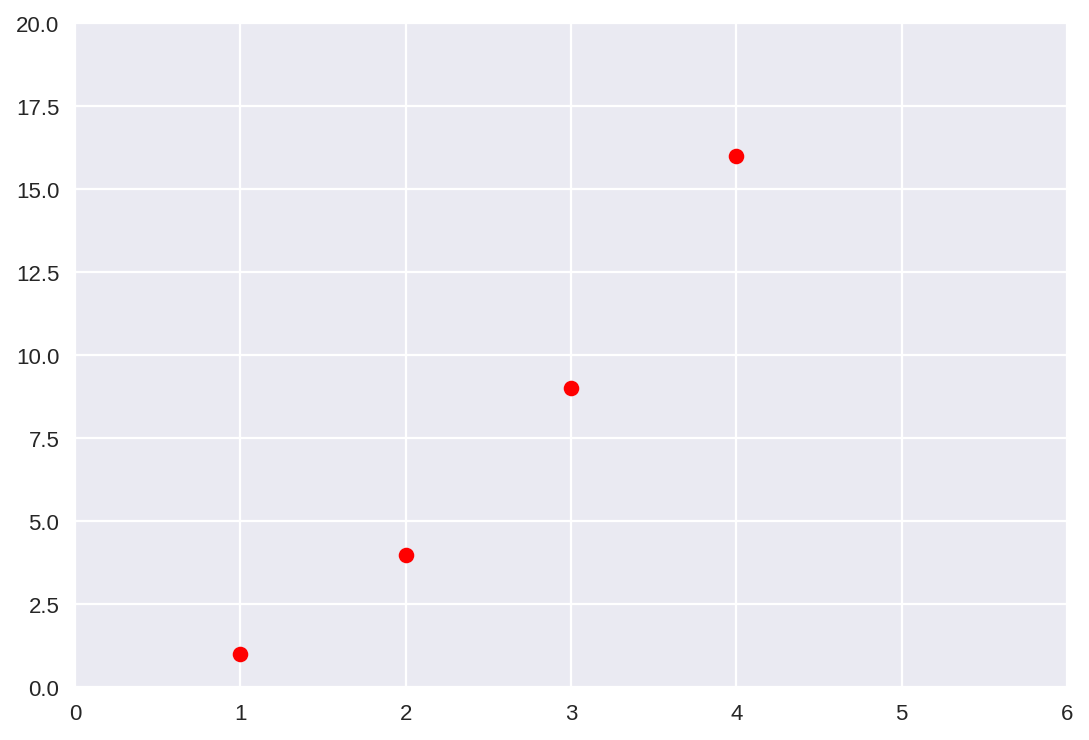

In [45]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()

### Effect of number of trees vs Test time

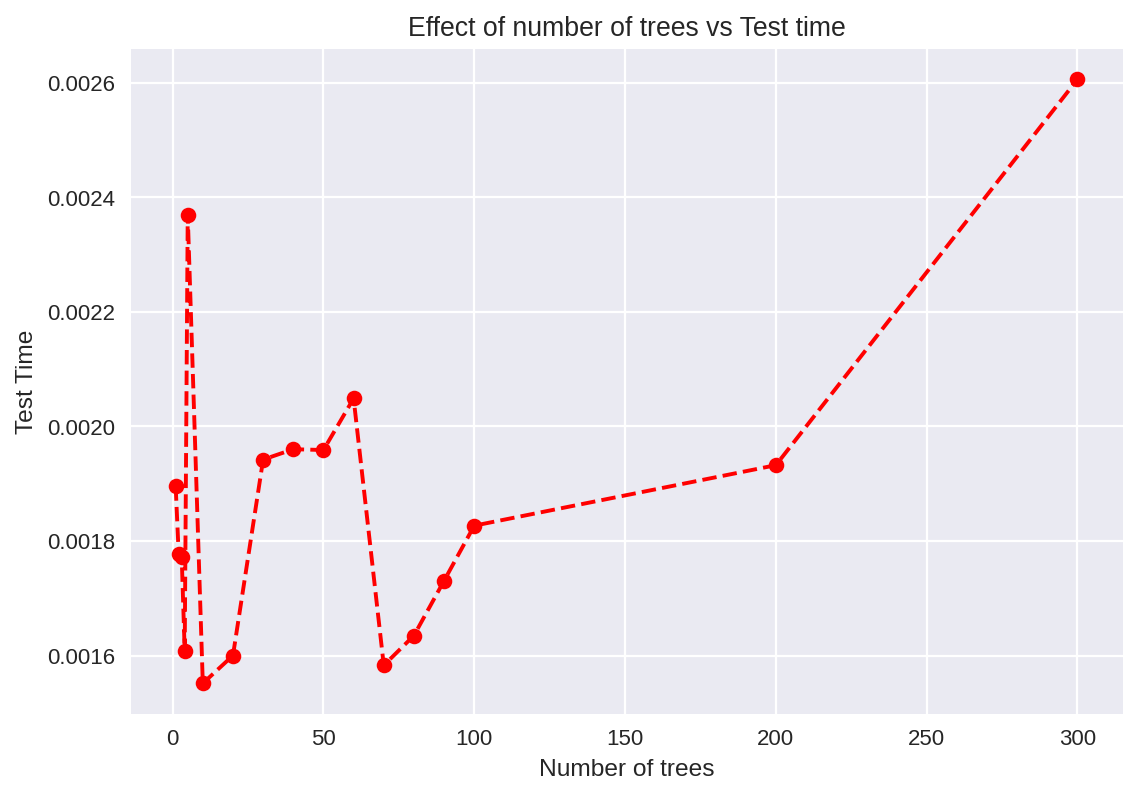

In [46]:
plt.plot(annoy_trees, annoy_test_time, 'or--')
plt.title('Effect of number of trees vs Test time')
plt.xlabel('Number of trees')
plt.ylabel('Test Time')
plt.grid(True)
plt.show()

### NMS Lib

In [47]:
!pip install nmslib

     |████████████████████████████████| 13.0MB 315kB/s 
     |████████████████████████████████| 194kB 39.9MB/s 


In [48]:
import nmslib

In [49]:
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(dataset)
index.createIndex({'post': 2}, print_progress=True)

In [50]:
# query for the nearest neighbors of the first datapoint
%timeit index.knnQuery(query, k=5)
ids, distances = index.knnQuery(query, k=5)

The slowest run took 8.43 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 33.3 µs per loop


In [51]:
# Get all nearest neighbors for all the datapoint
%timeit index.knnQueryBatch(dataset, k=5, num_threads=16)
neighbors = index.knnQueryBatch(dataset, k=5, num_threads=16)

1 loop, best of 3: 247 ms per loop


### Falconn

In [52]:
!pip install falconn

     |████████████████████████████████| 1.4MB 4.5MB/s 
  Created wheel for falconn: filename=FALCONN-1.3.1-cp36-cp36m-linux_x86_64.whl size=10581351 sha256=4ba32eb7c4f6b98dab27b66d823a190ebd278670b593ae47d84cda4673d43135
  Stored in directory: /root/.cache/pip/wheels/bf/36/96/d5538901888620fc0343c1ed9d5f87fce00869e00c12056ef8
Successfully built falconn


In [53]:
import falconn

In [54]:
parameters = falconn.LSHConstructionParameters()
num_tables = 1
parameters.l = num_tables
parameters.dimension = num_dimensions
parameters.distance_function = falconn.DistanceFunction.EuclideanSquared
parameters.lsh_family = falconn.LSHFamily.CrossPolytope
parameters.num_rotations = 1
parameters.num_setup_threads = 1
parameters.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
falconn.compute_number_of_hash_functions(16, parameters)

index = falconn.LSHIndex(parameters)
%time index.setup(dataset)

query_object = index.construct_query_object()
num_probes = 1
query_object.set_num_probes(num_probes)

%timeit query_object.find_k_nearest_neighbors(query, 5)

CPU times: user 11.6 ms, sys: 359 µs, total: 11.9 ms
Wall time: 12.5 ms
The slowest run took 25.72 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.34 µs per loop


In [55]:
query = dataset[5000]
print(query_object.find_k_nearest_neighbors(query, 5))

[5000]
